## Projeto sobre burnout no ambiente de trabalho. Escolhemos a **Regressão Logística Binária**, devido ser a mais apropriada, pois o objetivo é prever a probabilidade de um evento binário (por exemplo, "Burnout: Sim/Não")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/mental_health_workplace_survey.csv')

## Simulação de Dados

In [ ]:
# Configuração para reprodutibilidade
np.random.seed(42)
N_AMOSTRAS = 1000

# Dados Simulados
data = {
    'WorkHoursPerWeek': np.random.randint(30, 70, N_AMOSTRAS),
    'SleepHours': np.random.choice(['<6', '6-8', '>8'], N_AMOSTRAS, p=[0.3, 0.5, 0.2]),
    'Gender': np.random.choice(['Masculino', 'Feminino', 'Outro'], N_AMOSTRAS, p=[0.45, 0.45, 0.1]),
    'CommuteTime': np.random.choice(['Curto', 'Médio', 'Longo'], N_AMOSTRAS, p=[0.4, 0.3, 0.3]),
    'HasMentalHealthSupport': np.random.choice([0, 1], N_AMOSTRAS, p=[0.6, 0.4]), # 0=Não, 1=Sim
    'Burnout': np.random.choice([0, 1], N_AMOSTRAS, p=[0.75, 0.25]) # Target
}

df = pd.DataFrame(data)

# Visualização inicial
print("Primeiras 5 linhas do DataFrame:")
print(df.head())
print("\nTipos de Dados:")
print(df.dtypes)

Primeiras 5 linhas do DataFrame:
   WorkHoursPerWeek SleepHours     Gender CommuteTime  HasMentalHealthSupport  \
0                68         <6      Outro       Longo                       1   
1                58         >8   Feminino       Curto                       0   
2                44         >8  Masculino       Longo                       0   
3                37         <6  Masculino       Longo                       0   
4                50         <6   Feminino       Curto                       0   

   Burnout  
0        0  
1        0  
2        0  
3        0  
4        0  

Tipos de Dados:
WorkHoursPerWeek           int64
SleepHours                object
Gender                    object
CommuteTime               object
HasMentalHealthSupport     int64
Burnout                    int64
dtype: object


## Pré-Processamento e Divisão de Dados

In [ ]:
# Definindo as features
numerical_features = ['WorkHoursPerWeek']
categorical_features = ['SleepHours', 'Gender', 'CommuteTime', 'HasMentalHealthSupport']
target = 'Burnout'

# Dividir em treino e teste
X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


# Criar os objetos de pré-processamento
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combinar os transformadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

print("Pré-processamento definido (Escalonamento para Numéricas, One-Hot para Categóricas).")

Pré-processamento definido (Escalonamento para Numéricas, One-Hot para Categóricas).


## Modelagem e Treinamento

In [ ]:
# Criar o Pipeline completo
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

# Treinamento do modelo
model_pipeline.fit(X_train, y_train)
print("Modelo de Regressão Logística treinado com sucesso!")

Modelo de Regressão Logística treinado com sucesso!


In [ ]:
from sklearn import metrics

## Avaliação do Modelo


### Relatório de Classificação (Threshold = 0.5) ###
                 precision    recall  f1-score   support

Sem Burnout (0)       0.77      1.00      0.87       230
Com Burnout (1)       0.00      0.00      0.00        70

       accuracy                           0.77       300
      macro avg       0.38      0.50      0.43       300
   weighted avg       0.59      0.77      0.67       300

ROC AUC Score: 0.4845


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


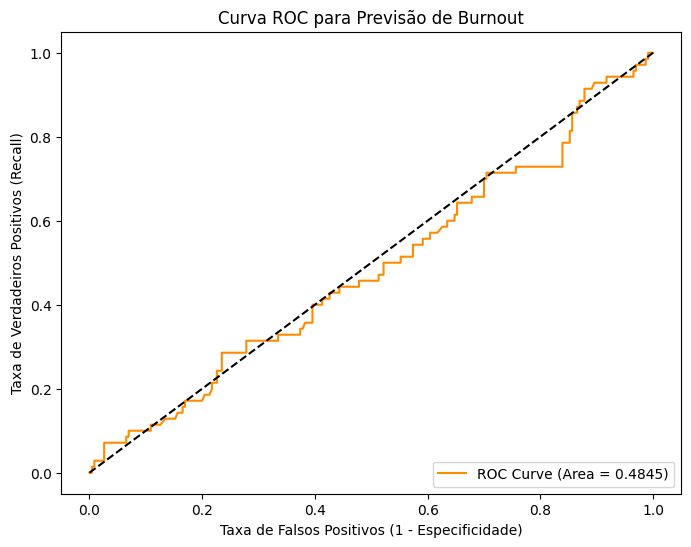

In [ ]:
# Previsões no conjunto de teste
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1] # Probabilidade de Burnout (classe 1)

# Cálculo das Métricas
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Usando um ponto de corte padrão (0.5) para Classification Report
y_pred_class = (y_pred_proba >= 0.5).astype(int)

# Relatório de Classificação
print("\n### Relatório de Classificação (Threshold = 0.5) ###")
print(classification_report(y_test, y_pred_class, target_names=['Sem Burnout (0)', 'Com Burnout (1)']))

# ROC AUC
print(f"ROC AUC Score: {roc_auc:.4f}")

# Visualização da Curva ROC
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba) # metrics definida
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (Area = {roc_auc:.4f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)')
plt.ylabel('Taxa de Verdadeiros Positivos (Recall)')
plt.title('Curva ROC para Previsão de Burnout')
plt.legend(loc="lower right")
plt.show()

## Análise de Score por Decil (Risco)

In [ ]:
# 'y_pred_proba': Array/Série com as probabilidades preditas (de 0 a 1) para a classe 1 (Burnout).

# Exemplo de Simulação (Descomente se precisar rodar sem o modelo completo)
# N_AMOSTRAS = 300
# y_test = np.random.choice([0, 1], N_AMOSTRAS, p=[0.75, 0.25])
# y_pred_proba = np.random.uniform(0.1, 0.9, N_AMOSTRAS)
# -----------------------------------------------------------

# DataFrame de resultados de teste
results_df = pd.DataFrame({
    'True_Burnout': y_test,
    'Probability_Score': y_pred_proba
})

# Classificar em 10 Decis
# pd.qcut divide os dados em quantis (grupos de 10% da população).
results_df['Decil'] = pd.qcut(
    results_df['Probability_Score'],
    q=10,
    labels=False,
    duplicates='drop'
)

# Reverter Decil: Mapeia o score mais alto (originalmente 9) para Decil 1,
# e o score mais baixo (originalmente 0) para Decil 10.
# Decil 1 = Maior Risco de Burnout.
results_df['Decil'] = results_df['Decil'].apply(lambda x: 10 - x)


# Calcular a Taxa Real de Burnout por Decil
decil_analysis = results_df.groupby('Decil').agg(
    Pessoas=('True_Burnout', 'count'),
    Casos=('True_Burnout', 'sum'),
    Min_Score=('Probability_Score', 'min'),
    Max_Score=('Probability_Score', 'max')
).reset_index()

decil_analysis['Taxa_Burnout'] = (decil_analysis['Casos'] / decil_analysis['Pessoas']) * 100
decil_analysis['%_Pessoas'] = (decil_analysis['Pessoas'] / decil_analysis['Pessoas'].sum()) * 100

# Ordenar por Decil (Decil 1 no topo, pois é o de maior risco)
decil_analysis = decil_analysis.sort_values(by='Decil', ascending=True)


# Apresentação da Tabela Final de Score (Decil)
print("\n### Análise de Score por Decil (Risco de Burnout) ###")
print("Ordem: Decil 1 (Maior Risco) -> Decil 10 (Menor Risco)")
print("Interpretação: Os indivíduos no Decil 1 possuem o maior Score de Probabilidade e, consequentemente, a maior Taxa Real de Burnout observada.")
print("----------------------------------------------------------------------------------------------------------")
print(decil_analysis[[
    'Decil',
    'Min_Score',
    'Max_Score',
    'Pessoas',
    'Casos'
]].rename(columns={'Taxa_Burnout': 'Taxa Real Burnout (%)'}).to_markdown(index=False, floatfmt=".3f"))


### Análise de Score por Decil (Risco de Burnout) ###
Ordem: Decil 1 (Maior Risco) -> Decil 10 (Menor Risco)
Interpretação: Os indivíduos no Decil 1 possuem o maior Score de Probabilidade e, consequentemente, a maior Taxa Real de Burnout observada.
----------------------------------------------------------------------------------------------------------
|   Decil |   Min_Score |   Max_Score |   Pessoas |   Casos |
|--------:|------------:|------------:|----------:|--------:|
|   1.000 |       0.339 |       0.392 |    30.000 |   7.000 |
|   2.000 |       0.284 |       0.338 |    30.000 |   6.000 |
|   3.000 |       0.258 |       0.283 |    30.000 |   9.000 |
|   4.000 |       0.240 |       0.257 |    30.000 |   6.000 |
|   5.000 |       0.223 |       0.239 |    30.000 |   4.000 |
|   6.000 |       0.200 |       0.222 |    30.000 |   8.000 |
|   7.000 |       0.190 |       0.200 |    30.000 |   9.000 |
|   8.000 |       0.175 |       0.190 |    30.000 |   2.000 |
|   9.000 |       0.160